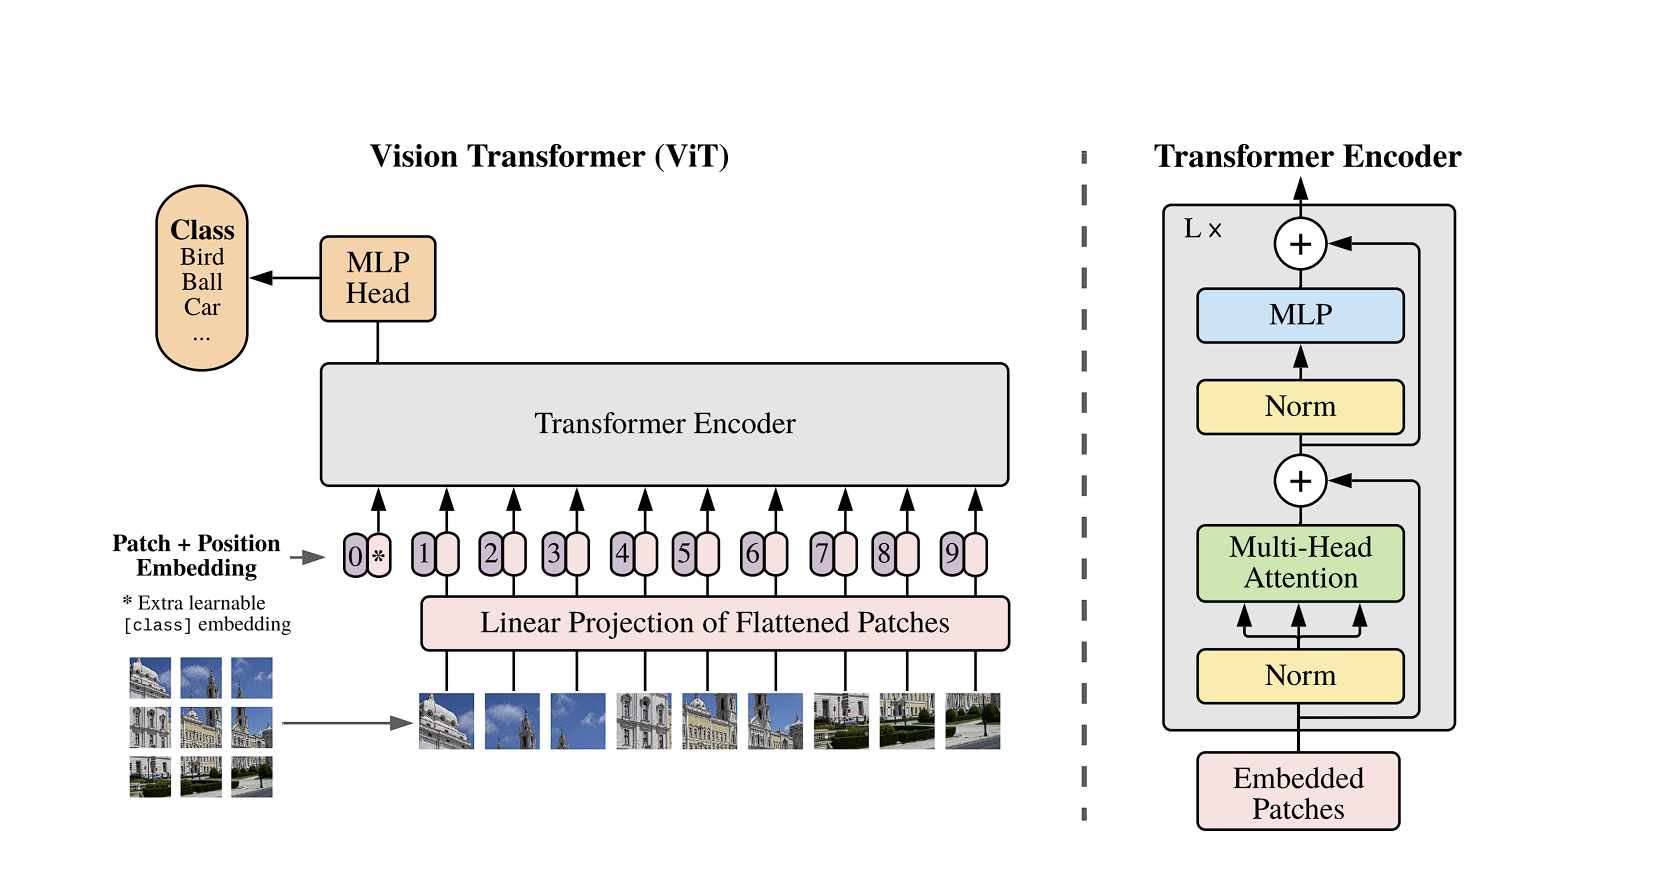

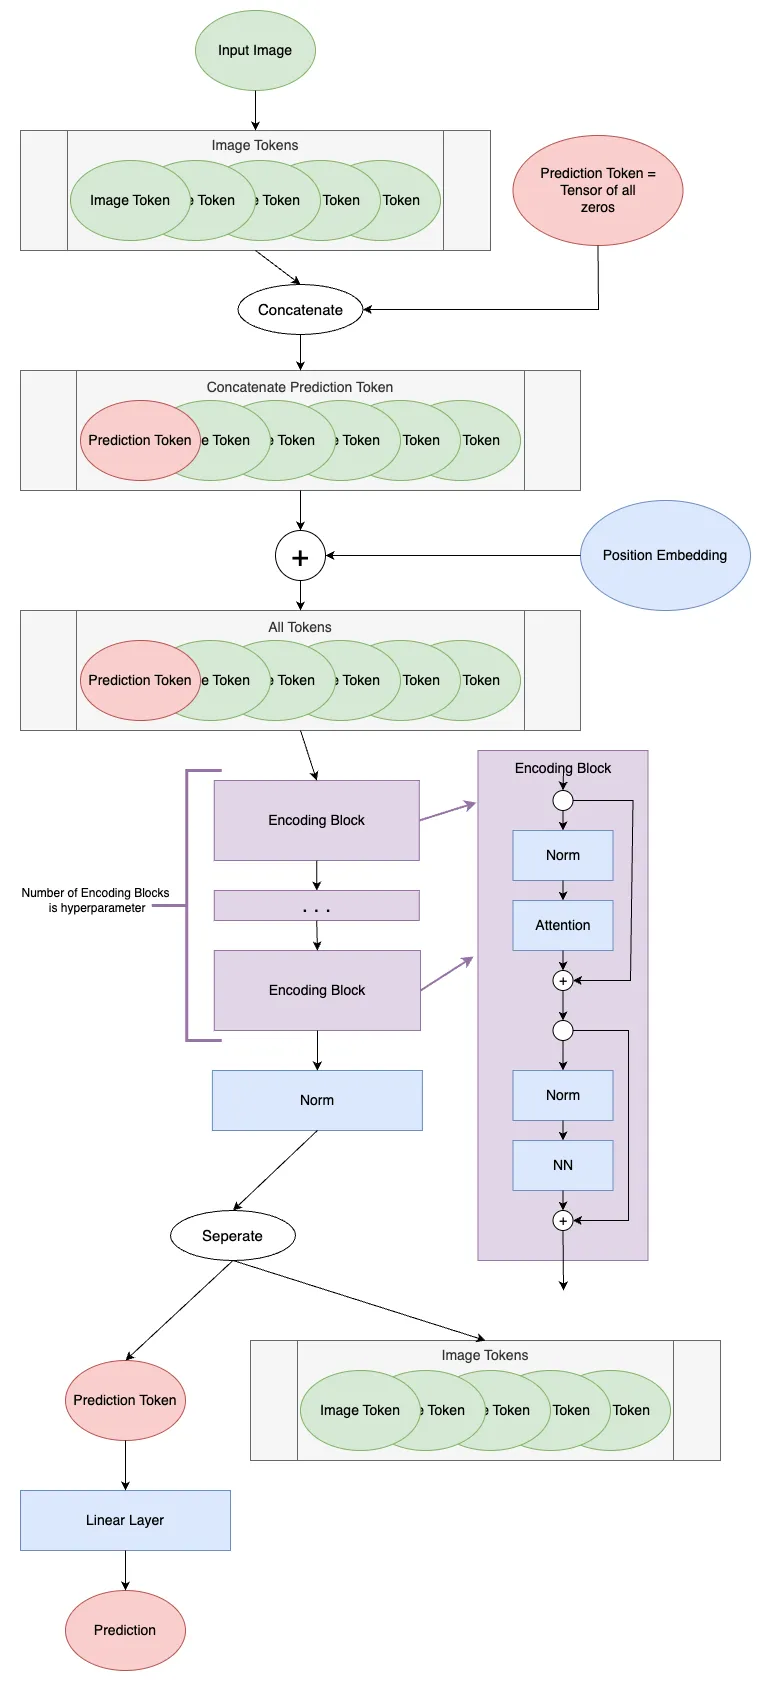

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [2]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

In [3]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.MLP = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        return self.MLP(x)


In [4]:
class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.0):
        super().__init__()
        inner_dim = heads * dim_head
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head**-0.5

        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(p=dropout)

        self.to_qkv = nn.Linear(dim, inner_dim*3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(p=dropout)
        ) if project_out else nn.Identity()
    
    def forward(self, x):
        output = self.norm(x)
        qkv = self.to_qkv(output).chunk(3, dim=-1)
        q, k, v = map(lambda t:rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        attn = self.dropout(attn)
        output = torch.matmul(attn, v)
        output = rearrange(output, 'b h n d -> b n (h d)')
        return self.to_out(output)

In [5]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.0):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads, dim_head, dropout),
                FeedForward(dim, mlp_dim, dropout)
            ]))
    
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

In [6]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool='cls'
                 ,channels=3, dim_head=64, dropout=0.0, emb_dropout=0.0):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size'

        num_patches = (image_height * image_width) // (patch_height * patch_width)
        patch_dim = channels * patch_height * patch_width

        assert pool in {'cls', 'mean'}, 'Pool must be either cls or mean'

        self.patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width), #(b, num_patches, patch_dim)
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim)
        )
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(p=emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        self.pool = pool
        self.to_latent = nn.Identity()
        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)

        b, n, _ = x.shape #n is the number of patches

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)

        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n+1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]
        return self.mlp_head(x)

In [7]:
vit = ViT(
    image_size=224,
    patch_size=16,
    num_classes=102,
    dim=768,
    depth=12,
    heads=12,
    mlp_dim=3072,
    pool='cls',
    channels=3,
    dim_head=64,
    dropout=0.1,
    emb_dropout=0.1
)

In [8]:
img = torch.randn(1, 3, 224, 224)  # batch size = 1
logits = vit(img)
print("Output shape:", logits.shape)

Output shape: torch.Size([1, 102])
